# Read the friction paramters from the flow simulation outputs and compute statistics

In [1]:
import numpy as np
import vtk
import pyvista as pv
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pickle

In [2]:
cm = 1/2.54

In [3]:
c_permanent = [46/255, 82/255, 102/255]
c_init_0    = [220/255, 196/255, 142/255]
#c_init_1    = [234/255, 239/255, 211/255]
c_init_1    = [179/255, 192/255, 164/255]
c_init_2   = [166/255, 127/255, 142/255]
c_init_3    = [102/255, 16/255, 31/255]


color_pall_3 = [c_permanent, c_init_0, c_init_1, c_init_2, c_init_3]

c_0 = [151, 157, 172]
c_1 = [92, 103, 125]
c_2 = [4, 102, 200]
c_3 = [2, 62, 125]
c_4 = [46, 82, 102]
c_5 = [0, 18, 51]

color_degr = [c_0, c_1, c_2, c_3, c_4, c_5]
color_degr = [[idc/255 for idc in col] for col in color_degr]


In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Read output_simulations

In [5]:
def read_pickle(path):
    with open(path,'rb') as f:
        file = pickle.load(f)
    return file

In [6]:
columns_names = ['time_step', 'flow_rate', 'pos_x', 'pos_y', 'pipe_diam', 'seed']
colors        = ['darkblue','darkred','darkorange']

In [7]:
pressure_list = [35,40,45,50]
out_list = []

for pressure in pressure_list:
    out = []
    for i in range(5):
        path = 'output_2022/out_{1}bar_2021/out_{0}/save_flow/output_simulations_{0}.pickle'.format(i,pressure)
        out.append(read_pickle(path))
        
    out = np.concatenate(out)
    out_list.append(out)

In [8]:
out_list[0].shape

(600, 6)

In [9]:
out_df = []
for out in out_list:
    data = {}
    data['time_step'] = [t[0] for t in out[:,2]]
    data['flow_rate'] = [t[1] for t in out[:,2]]
    data['pos_x']     = [t[0] for t in out[:,3]]
    data['pos_y']     = [t[1] for t in out[:,3]]
    data['pipe_diam'] = [t[3] for t in out[:,3]]
    data['seed']      = [t for t in out[:,4]]
    data['case_nb']   = [t for t in out[:,5]]
    out_df.append(pd.DataFrame(data))

## Read save head vtk   

In [10]:
import pyvista as pv    

In [16]:
pressure_list

[35, 40, 45, 50]

In [11]:
re_set = []
f_set  = []
v_set  = []
for i in pressure_list:
    count = 0
    re_cas_1 = []
    f_cas_1  = []
    v_cas_1  = []
    re_cas_2 = []
    f_cas_2  = []
    v_cas_2  = []
    
    for j in range(5):
        path = 'output_2022/out_{}bar_2021/out_{}/save_karst/'.format(i,j)
        
        for nb in range(10):
            cas_1 = pv.read(path+'karst_flow_1d_2000000{:02}_cas_1.vtk'.format(count))
            cas_2 = pv.read(path+'karst_flow_1d_2000000{:02}_cas_2.vtk'.format(count))
            
            re_cas_1.append(cas_1['Re[-]'])
            f_cas_1.append(cas_1['f[-]'])
            v_cas_1.append(cas_1['v[m/s]'])
            re_cas_2.append(cas_2['Re[-]'])
            f_cas_2.append(cas_2['f[-]'])
            v_cas_2.append(cas_2['v[m/s]'])
            count+=1
            
        
    re_set.append([np.concatenate(re_cas_1),np.concatenate(re_cas_2)])
    f_set.append([np.concatenate(f_cas_1),np.concatenate(f_cas_2)])
    v_set.append([np.concatenate(v_cas_1),np.concatenate(v_cas_2)])

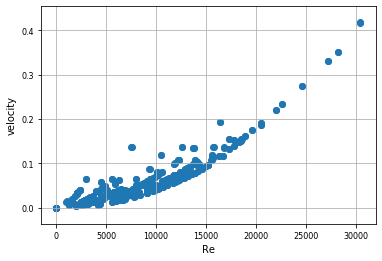

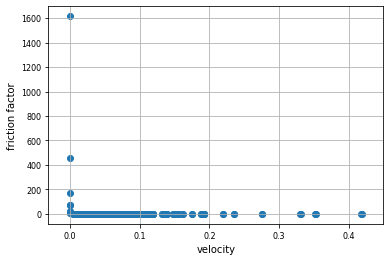

In [12]:
plt.scatter(re_set[0][0][:500],v_set[0][0][:500])
plt.xlabel('Re')
plt.ylabel('velocity')
plt.grid()
plt.show()

plt.scatter(v_set[0][0][:500],f_set[0][0][:500])
plt.xlabel('velocity')
plt.ylabel('friction factor')
plt.grid()
plt.show()

In [24]:
i = 1
f_set[i][0].shape,  f_set[i][1][f_set[i][1]<np.quantile(f_set[i][1],0.99)].shape

((211076,), (297171,))

In [28]:
print('FRICTION FACTOR\n')

for i in range(len(pressure_list)):
    quantile = 0.999
    minv     = min([np.min(f_set[i][0]),np.min(f_set[i][1])])
    medianv  = np.median(np.concatenate([f_set[i][0],f_set[i][1]]))
    meanv    = np.mean(np.concatenate([f_set[i][0][f_set[i][0]<np.quantile(f_set[i][0],quantile)],f_set[i][1][f_set[i][1]<np.quantile(f_set[i][1],quantile)]]))
    maxv     = max([np.max(f_set[i][0][f_set[i][0]<np.quantile(f_set[i][0],quantile)]),np.max(f_set[i][1][f_set[i][1]<np.quantile(f_set[i][1],quantile)])])
    
    print('***{} bar***'.format(pressure_list[i]))
    print('min value : {:0.3f}'.format(minv))
    print('median value : {:0.3f}'.format(medianv))
    print('mean value : {:0.3}'.format(meanv))
    print('max value : {:0.3f}\n'.format(maxv))

FRICTION FACTOR

***35 bar***
min value : 0.018
median value : 0.045
mean value : 1.69
max value : 850.360

***40 bar***
min value : 0.018
median value : 0.045
mean value : 1.57
max value : 799.002

***45 bar***
min value : 0.018
median value : 0.044
mean value : 1.41
max value : 712.050

***50 bar***
min value : 0.018
median value : 0.044
mean value : 1.27
max value : 622.472



## Read vtk test

In [70]:
path  = 'output_2021/out_{}bar_2021/out_0/save_head/'.format(35)
files = os.listdir(path)    
#flow_3d_cas_1 = pv.read(path+files[0])

In [66]:
path_karst = 'output_2021/out_{}bar_2021/out_0/save_karst/'.format(35)
files = os.listdir(path_karst)    

In [72]:
files[0][18:]

'cas_1.vtk'

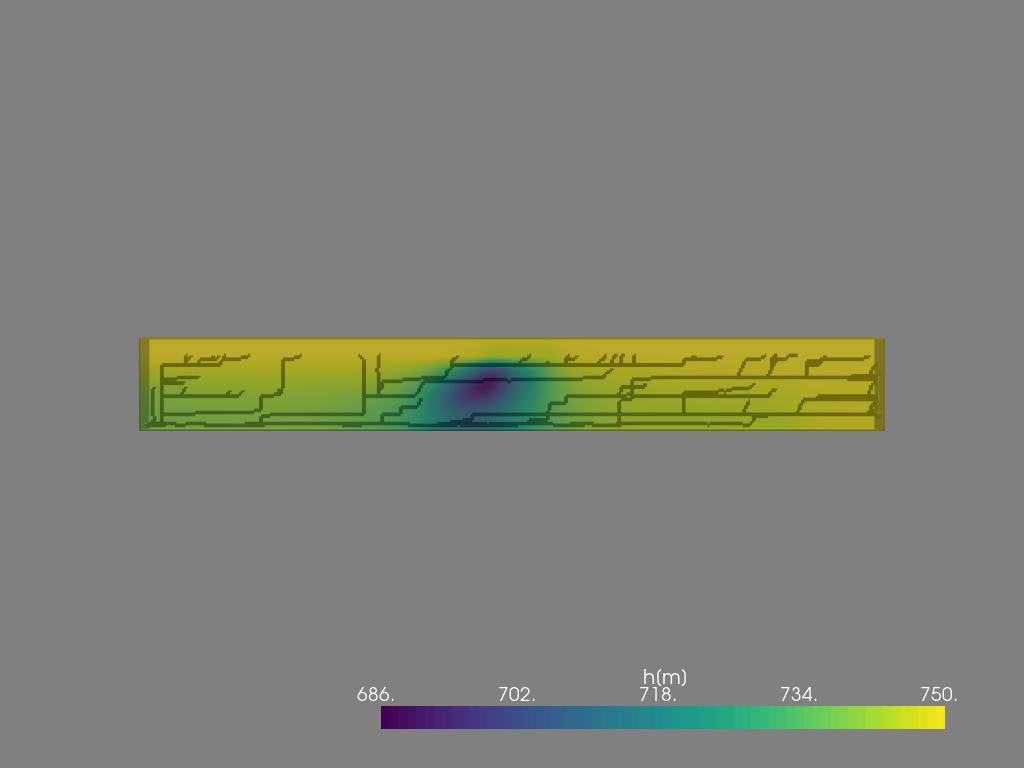

In [83]:
#4 pressure for karst type 1
out = 2
karst_nb = 5 #seulement des chiffres impaires pour le cas 1
for i in (pressure_list[0:1]):
    path_head  = 'output_2021/out_{}bar_2021/out_{}/save_head/'.format(i, out)    
    path_karst = 'output_2021/out_{}bar_2021/out_{}/save_karst/'.format(i, out)
    files_head = os.listdir(path_head)
    name_head  = files_head[karst_nb][8:]
    
    if name_head[0][18:]!='cas_1.vtk':
        karst_nb +=1
        files_head = os.listdir(path_head)
        name_head  = files_head[karst_nb][8:]
        

    flow_3d_cas1  = pv.read(path_head+files_head[0])    
    karst_1d_cas1 = pv.read(path_karst+'karst_1d_'+name_head)

    
    plotter = pv.Plotter()
    cpos = (0.0,-10.0,0.0)
    #cpos = (10.0,.0,0.0)
    plotter.camera_set = True
    plotter.set_background('grey')
    plotter.add_mesh(flow_3d_cas1, opacity=0.6, smooth_shading=True, cmap='viridis')#clim=[400,400+int(i)*10])
    plotter.add_mesh(karst_1d_cas1, color='black', line_width=4, categories=True)
    plotter.show(use_panel=True,cpos=cpos)


In [39]:
flow_3d_cas_1 = pv.read('output_2021/out_35bar_2021/out_0/save_head/flow_3d_200000000_cas_1.vtk')
flow_3d_cas_2 = pv.read('output_2021/out_35bar_2021/out_0/save_head/flow_3d_200000000_cas_1.vtk')

In [40]:
flow_3d_cas_1

UnstructuredGrid (0x1d5d6bdef48)
  N Cells:	440000
  N Points:	470373
  X Bounds:	0.000e+00, 2.000e+03
  Y Bounds:	0.000e+00, 1.100e+02
  Z Bounds:	0.000e+00, 2.500e+02
  N Arrays:	4

In [41]:
keys = flow_3d_cas_1.array_names
keys

['h[m]', 'v[m/s]', 'Re[-]', 'f[-]']

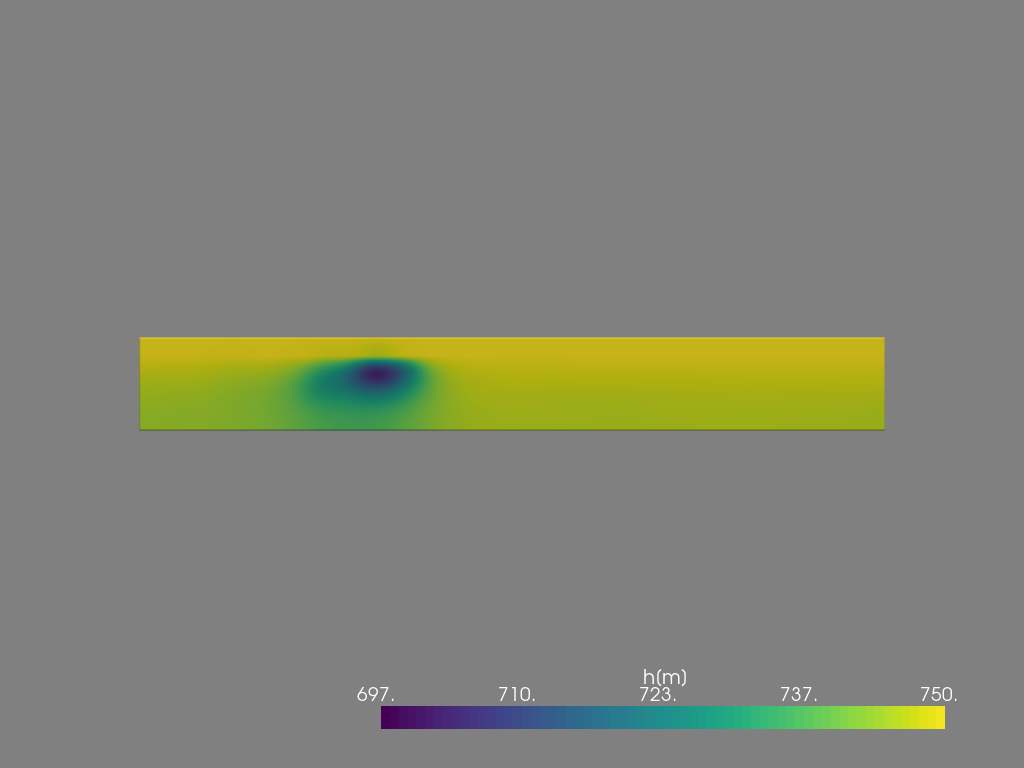

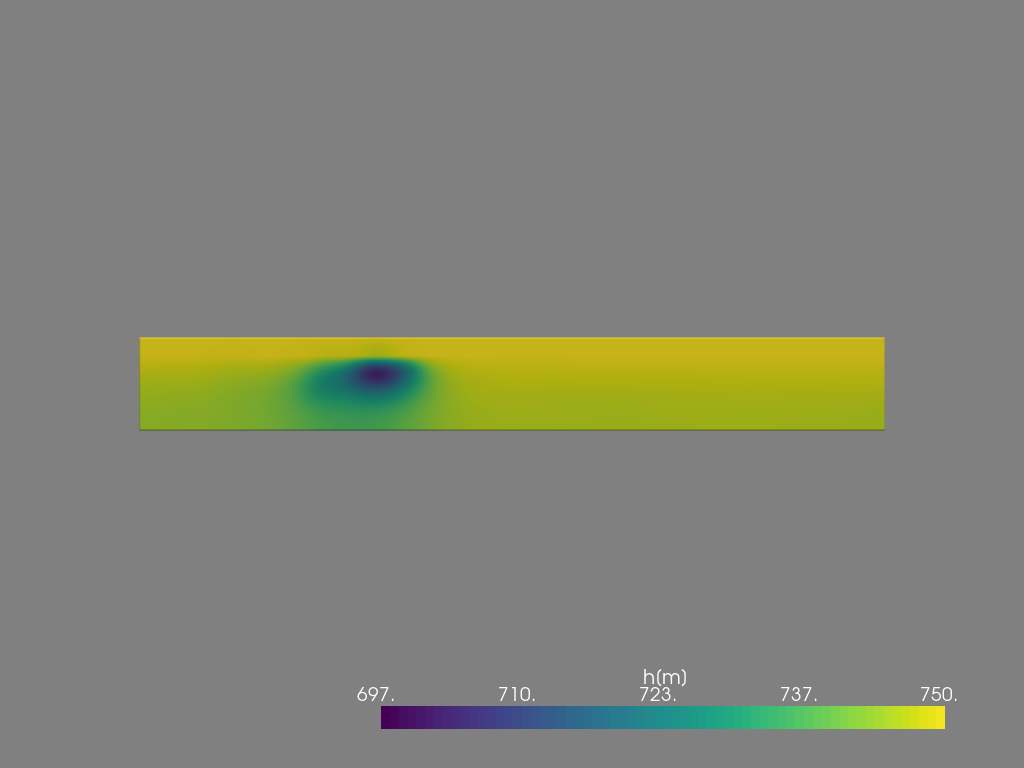

In [43]:
plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(flow_3d_cas_1,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)
plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(flow_3d_cas_2,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)

## Read save karst vtk

In [10]:
karst_1d_cas1 = pv.read('simu_out_21-07-2021/save_karst/karst_1d_200000000_cas_1.vtk')
karst_1d_cas2 = pv.read('simu_out_21-07-2021/save_karst/karst_1d_200000000_cas_2.vtk')

In [11]:
karst_1d_cas1

UnstructuredGrid (0x7f6ca14879a0)
  N Cells:	4510
  N Points:	4458
  X Bounds:	7.000e+00, 1.997e+03
  Y Bounds:	5.500e+01, 5.500e+01
  Z Bounds:	7.000e+00, 2.020e+02
  N Arrays:	1

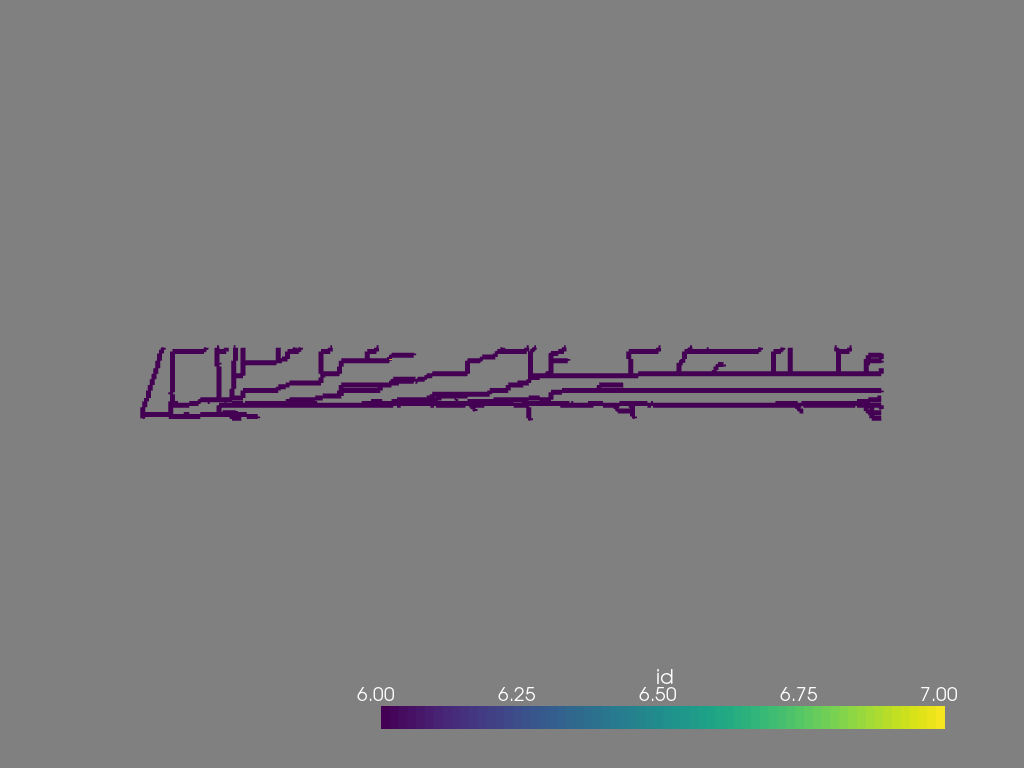

In [90]:
plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(karst_1d_cas1 ,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)

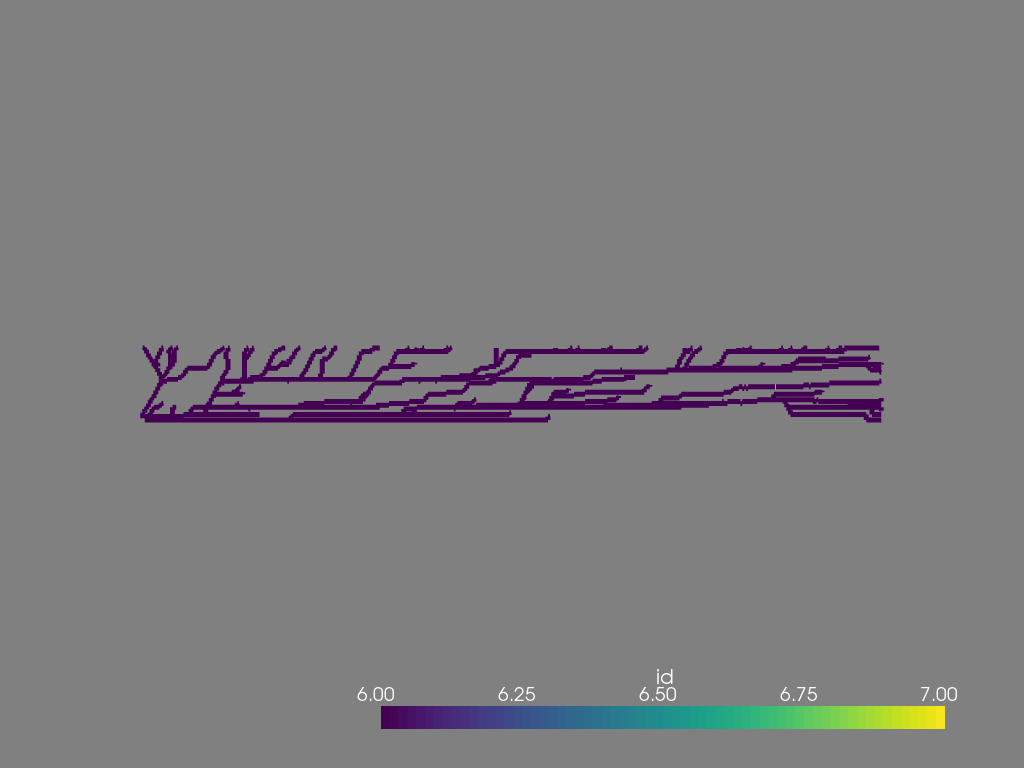

In [91]:
plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(karst_1d_cas2,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)

In [20]:
karst_flow_cas2 = pv.read('output_2021/out_35bar_2021/out_0/save_karst/karst_flow_1d_200000000_cas_2.vtk')

In [21]:
karst_flow_cas2

UnstructuredGrid (0x7f7834351520)
  N Cells:	6136
  N Points:	6107
  X Bounds:	2.000e+00, 1.997e+03
  Y Bounds:	5.500e+01, 5.500e+01
  Z Bounds:	7.000e+00, 2.020e+02
  N Arrays:	4

In [25]:
karst_flow_cas2['Re[-]']

array([ 45.21330044, 140.76924622, 249.60729303, ..., 221.54766458,
       254.41628775, 282.43109917])

In [72]:
karst_flow_cas2 = karst_flow_cas2.cell_data_to_point_data()

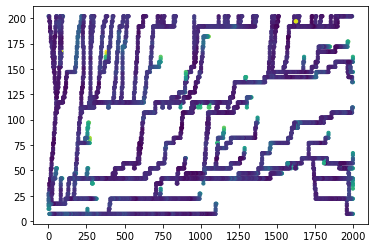

In [77]:
plt.scatter(karst_flow_cas2.points[:,0],karst_flow_cas2.points[:,2],10,karst_flow_cas2[keys[3]][:]);

DEPRECATED: please use `.set_active_scalars` instead.


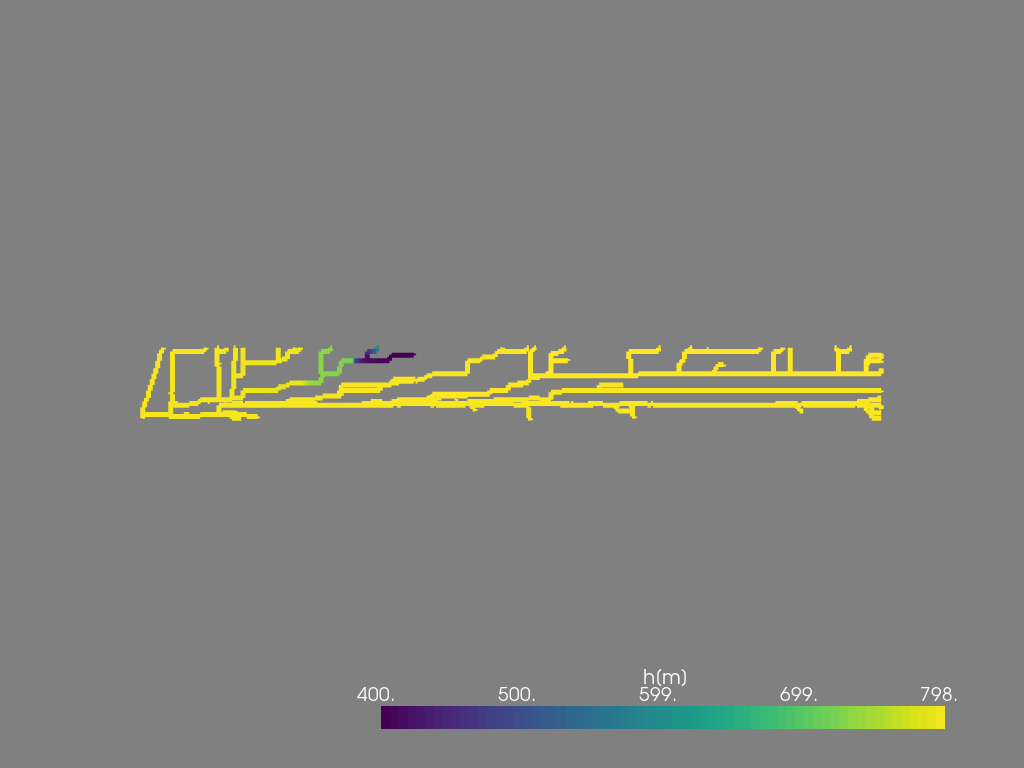

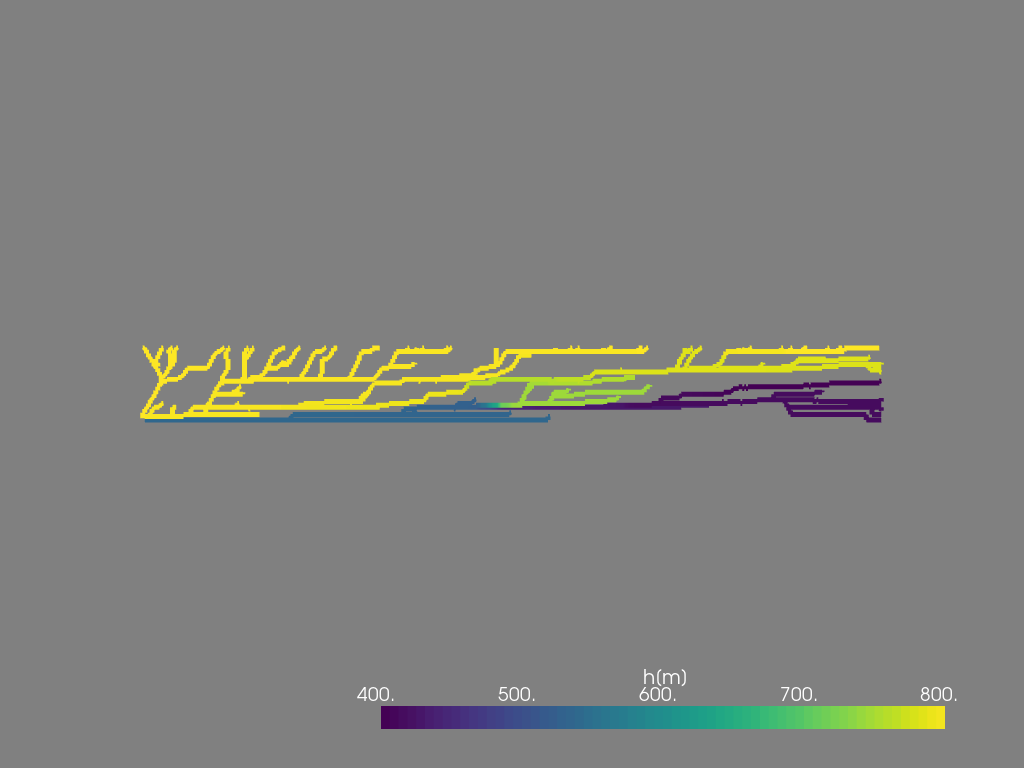

In [21]:
plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
karst_flow_cas1.set_active_scalar(keys[0])
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(karst_flow_cas1 ,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)

plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
karst_flow_cas2.set_active_scalar(keys[0])
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(karst_flow_cas2 ,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)

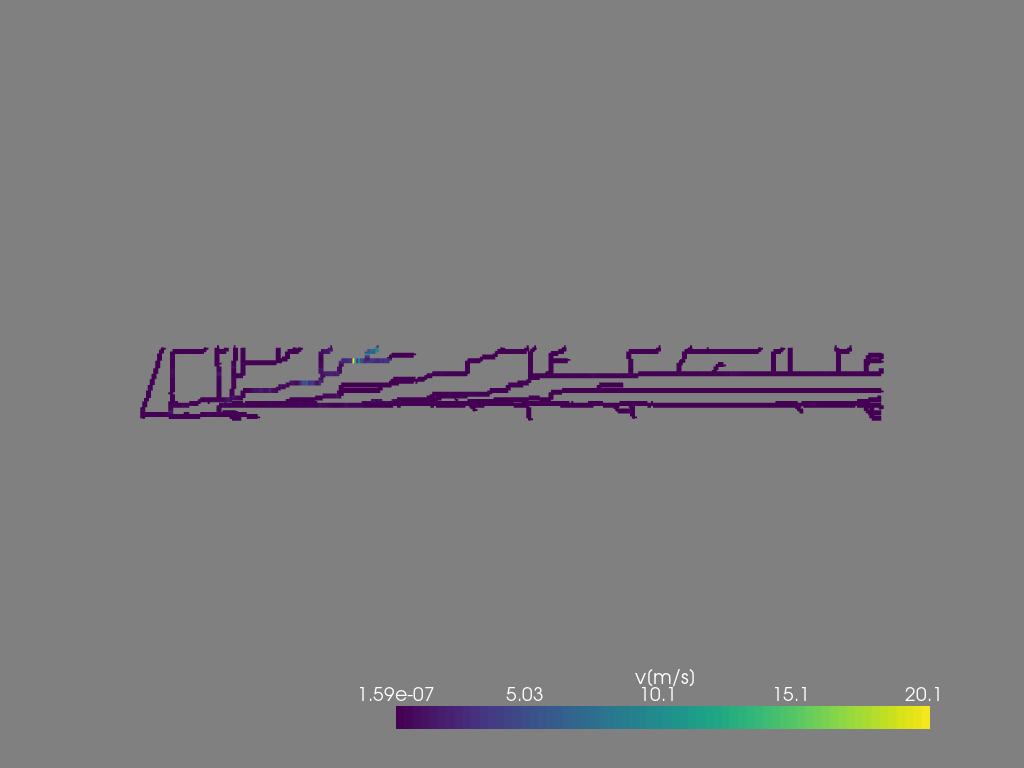

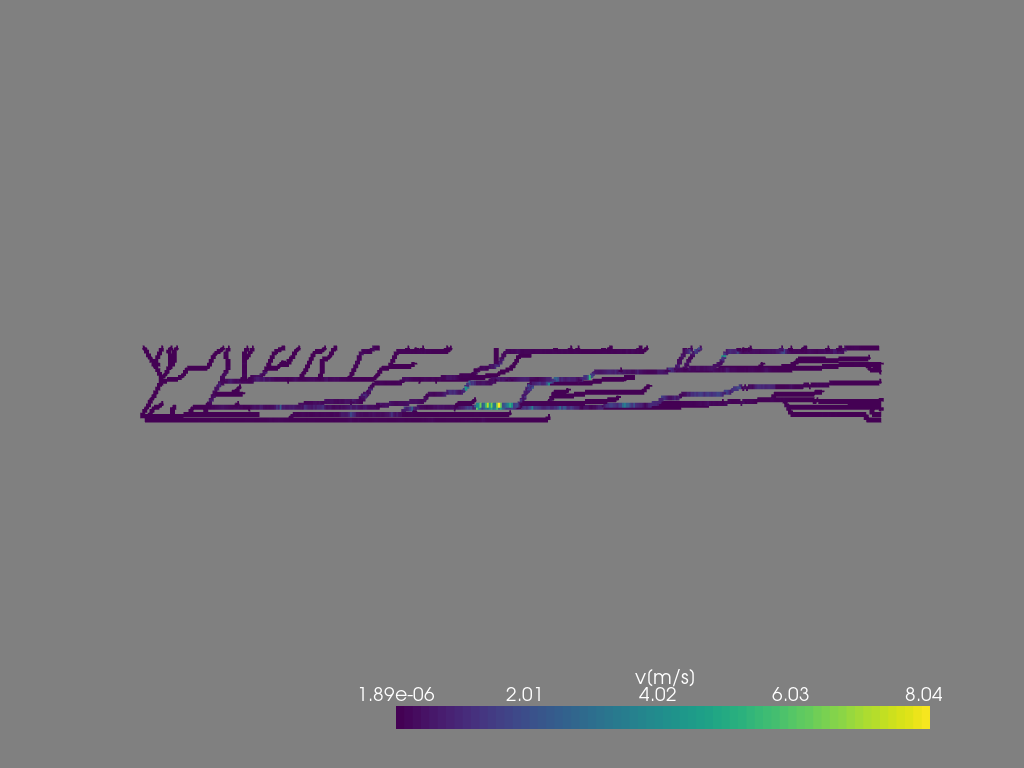

In [97]:
plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
karst_flow_cas1.set_active_scalar(keys[1])
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(karst_flow_cas1 ,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)

plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
karst_flow_cas2.set_active_scalar(keys[1])
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(karst_flow_cas2 ,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)

In [23]:
karst_flow_cas1[keys[2]] = np.log10(karst_flow_cas1[keys[2]])

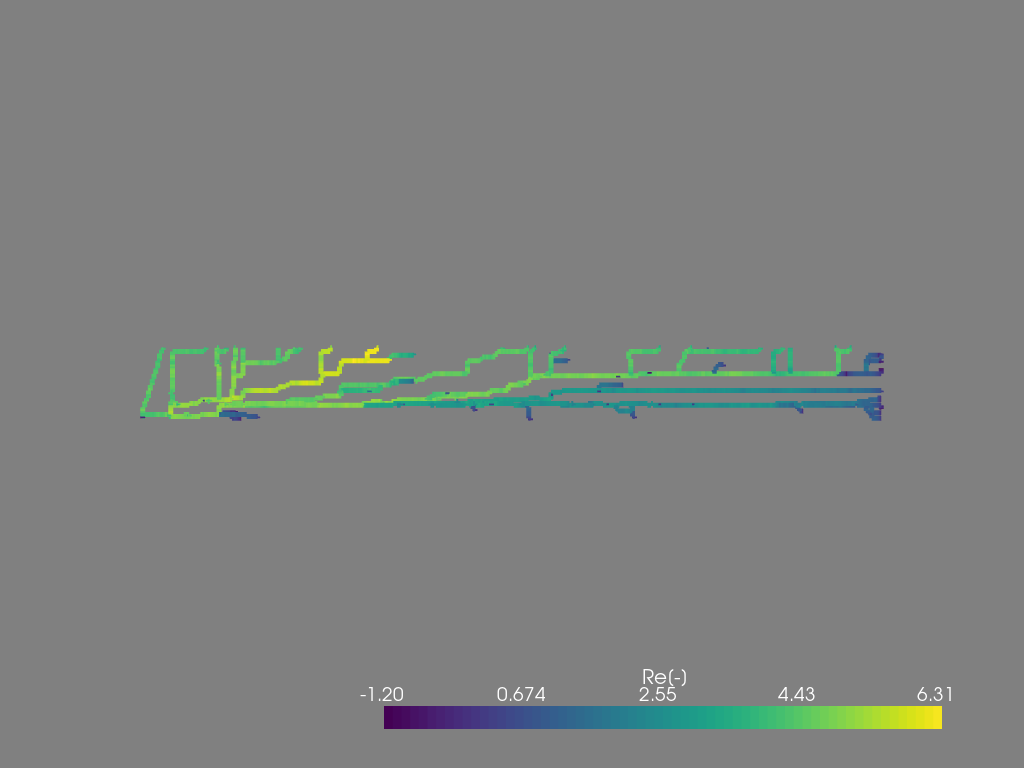

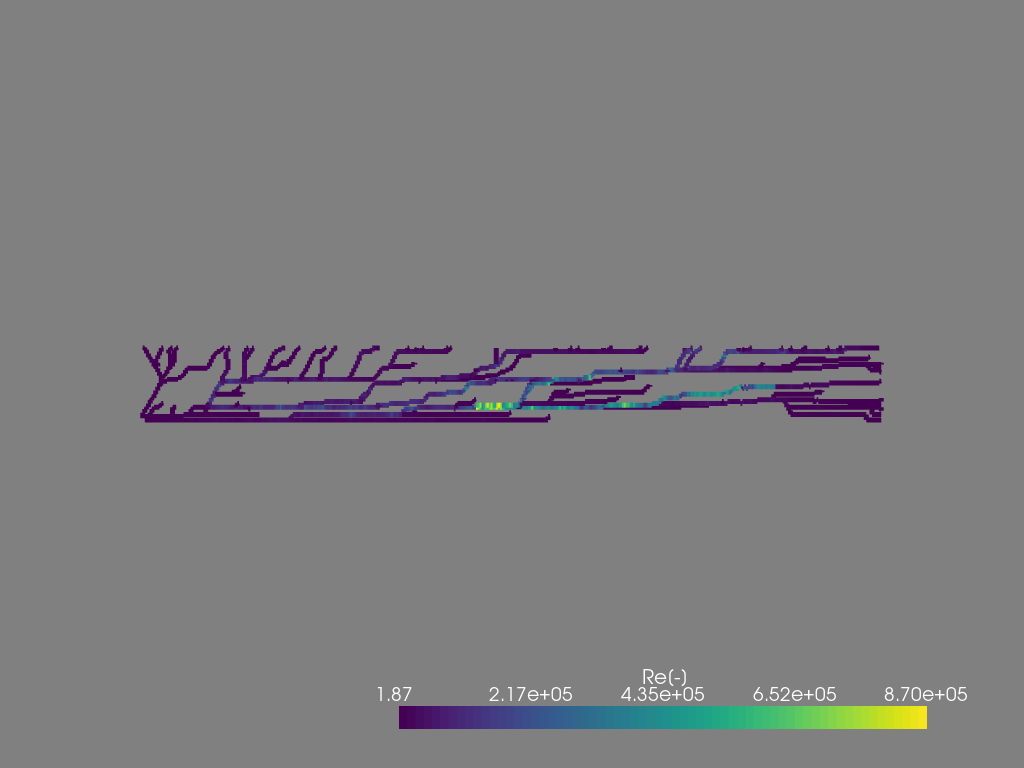

In [24]:
plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
karst_flow_cas1.set_active_scalar(keys[2])
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(karst_flow_cas1 ,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)

plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
karst_flow_cas2.set_active_scalar(keys[2])
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(karst_flow_cas2 ,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)

In [27]:
#karst_flow_cas1[keys[3]] = np.log10(karst_flow_cas1[keys[3]])
karst_flow_cas2[keys[3]] = np.log10(karst_flow_cas2[keys[3]])

In [30]:
karst_flow_cas2[keys[3]].shape

(6136,)

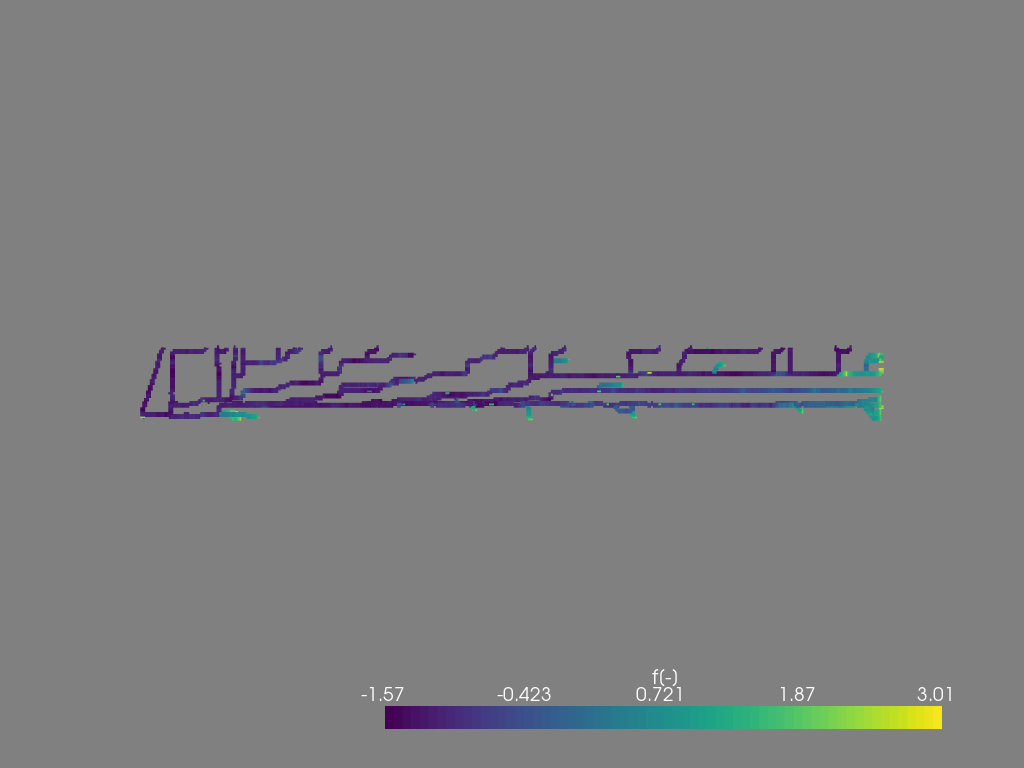

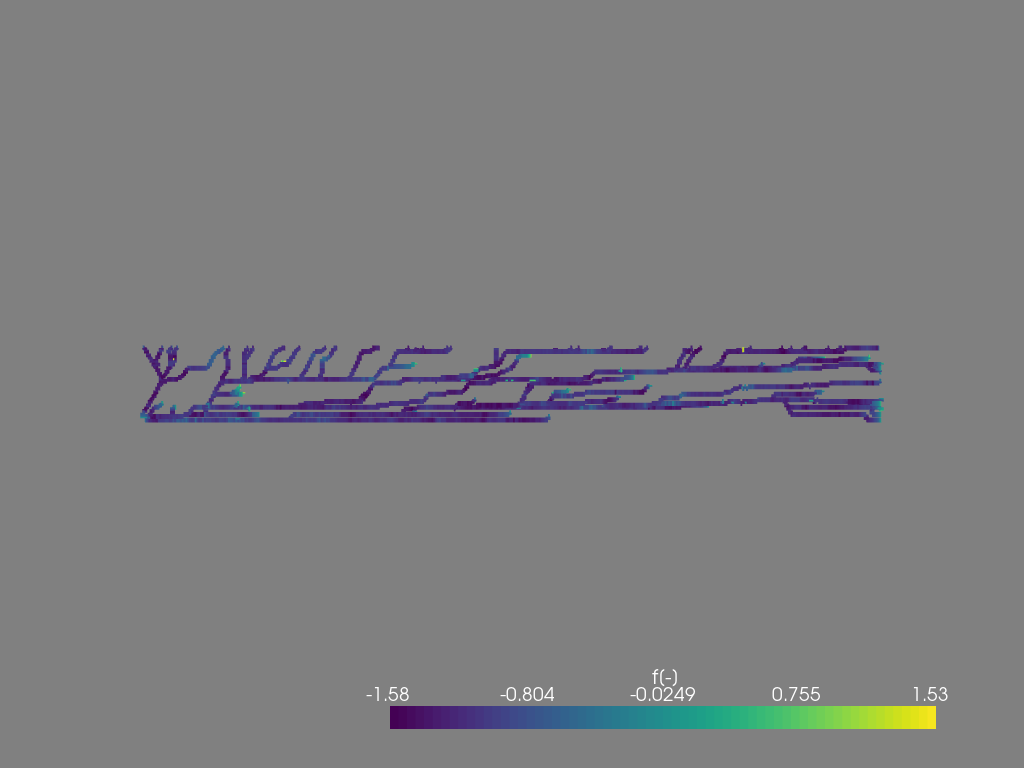

In [28]:
plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
karst_flow_cas1.set_active_scalar(keys[3])
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(karst_flow_cas1 ,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)

plotter = pv.Plotter()
cpos = (0.0,-10.0,0.0)
#cpos = (10.0,.0,0.0)
karst_flow_cas2.set_active_scalar(keys[3])
plotter.camera_set = True
plotter.set_background('grey')
plotter.add_mesh(karst_flow_cas2 ,opacity=1,smooth_shading=True,line_width=5)
plotter.show(use_panel=True,cpos=cpos)

In [1]:
karst_out = karst_flow_cas2
for k in keys:
    v_max = karst_out[k].max()
    v_min = karst_out[k].min()
    v_mean = karst_out[k].mean()
    v_std  = karst_out[k].std()
    print('*********')
    print('The field {} has for maximum value {:0.3} and minimum value {:0.3}.'.format(k,v_max, v_min))
    print('The mean value is {:0.3} and the std corresponds to {:0.3}.'.format(v_mean, v_std))

NameError: name 'karst_flow_cas2' is not defined

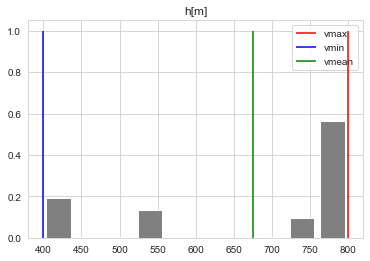

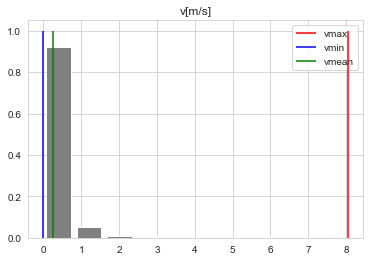

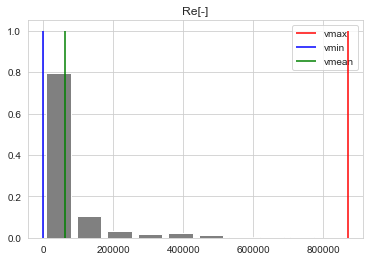

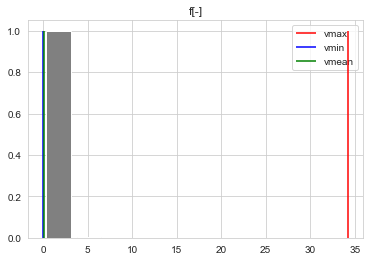

In [106]:
for i,k in enumerate(keys):
    plt.hist(karst_out[k],weights=np.ones(len(karst_out[k]))/len(karst_out[k]),zorder=9,rwidth=0.8,color='grey')
    v_max = karst_out[k].max()
    v_min = karst_out[k].min()
    v_mean = karst_out[k].mean()
    v_std  = karst_out[k].std()
    
    plt.vlines(v_max,0,1,label='vmax',color='red',zorder=10)
    plt.vlines(v_min,0,1,label='vmin',color='blue',zorder=10)
    plt.vlines(v_mean, 0,1, label='vmean',color='green',zorder=10)
    plt.legend()
    plt.grid(True)
    plt.title(k)
    plt.show()